**Author: Mariana Chaves**

**Date: August 2022**

In this notebook includes:

- Gridsearch on naive bayes and logistic regression models.
- Training those same models using leave-one-movie-out cross-validation. 
- Training those same models using leave-some-movies-out cross-validation.

Two classifications tasks are considered: 

(1) Classifying gender at dialogue level, that is, each sample corresponds to a dialogue.

(2) Classifying gender at character level, that is, each sample corresponds to all dialogues of a character.

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate, LeaveOneGroupOut,GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import sklearn
import pickle
import matplotlib.pyplot as plt
import tqdm
import time

In [6]:
# Go to main directory
%cd ..

/content/drive/Othercomputers/My Laptop/Documents/UCA DSAI/Internship 2/Code/text-models


# Load Cornell

These versions include the preprocessing steps applied in Schofield, A., & Mehr, L. (2016). Gender-Distinguishing Features in Film Dialogue. Proceedings of the Fifth Workshop on Computational Linguistics for Literature, 32–39. https://doi.org/10.18653/v1/W16-0204. 

See ```cornell_corpus_preprocessing.ipynb``` for the code related to the preprocessing.

One dataset is at dialogue level, and the other one, at character level.

In [7]:
# Loading preprocessed cornell
cornell_prepro = pd.read_pickle("datasets/cornell_corpus/cornell_prepro.pkl")  
cornell_prepro_characters = pd.read_pickle("datasets/cornell_corpus/cornell_prepro_characters.pkl")  

# Bag of words and TF-IDF

Using the parameter `vocabulary` from `CountVectorizer`, we can select the unigrams, bigrams and trigrams that we want to take into consideration. We identify the ones that appear at least 5 times and set them as our vocabulary. 

**1. Getting our vocabularies**

In [8]:
# Lower case
cornell_prepro['text'] = cornell_prepro['text'].str.lower()
cornell_prepro_characters['text'] = cornell_prepro_characters['text'].str.lower()

In [9]:
# Get all unigrams
vectorizer = CountVectorizer(ngram_range = (1,1))
n_grams = vectorizer.fit_transform(cornell_prepro['text'])
# Identify unigrams that showed up 5 or more times
freqs = zip(vectorizer.get_feature_names_out(), np.asarray(n_grams.sum(axis=0)).ravel())
important_unigrams = [f[0] for f in freqs if f[1]>=5]
print('unigrams that show up 5 or more times:', len(important_unigrams))


# Get all unigrams, bigrams and trigrams
vectorizer = CountVectorizer(ngram_range = (1,3))
n_grams = vectorizer.fit_transform(cornell_prepro['text'])
# Identify n-grams that showed up 5 or more times
freqs = zip(vectorizer.get_feature_names_out(), np.asarray(n_grams.sum(axis=0)).ravel())
important_unibitrigrams = [f[0] for f in freqs if f[1]>=5]
print('unigrams, bigrams and trigrams that show up 5 or more times:', len(important_unibitrigrams))

unigrams that show up 5 or more times: 11233
unigrams, bigrams and trigrams that show up 5 or more times: 65309


**2. Bag of words matrices (raw frequency)**

Matrix of token counts

In [ ]:
# Dialogue level

# For unigrams
BOW_model_unigrams = CountVectorizer(ngram_range = (1,1), vocabulary = important_unigrams)
BOW_unigrams = BOW_model_unigrams.fit_transform(cornell_prepro['text'])

# For unigrams, bigrams, and trigrams
BOW_model_unibitrigrams = CountVectorizer(ngram_range = (1,3), vocabulary = important_unibitrigrams)
BOW_unibitrigrams = BOW_model_unibitrigrams.fit_transform(cornell_prepro['text'])

In [10]:
# Character level

# For unigrams
BOW_model_unigrams = CountVectorizer(ngram_range = (1,1), vocabulary = important_unigrams)
BOW_unigrams_characters = BOW_model_unigrams.fit_transform(cornell_prepro_characters['text'])

# For unigrams, bigrams, and trigrams
BOW_model_unibitrigrams = CountVectorizer(ngram_range = (1,3), vocabulary = important_unibitrigrams)
BOW_unibitrigrams_characters = BOW_model_unibitrigrams.fit_transform(cornell_prepro_characters['text'])

**3 TF-IDF matrices**

In [ ]:
# Dialogue level

# For unigrams
TFIDF_model_unigrams = TfidfVectorizer(ngram_range = (1,1), vocabulary = important_unigrams)
TFIDF_unigrams = TFIDF_model_unigrams.fit_transform(cornell_prepro['text'])

# For unigrams, bigrams, and trigrams
TFIDF_model_unibitrigrams = TfidfVectorizer(ngram_range = (1,3), vocabulary = important_unibitrigrams)
TFIDF_unibitrigrams = TFIDF_model_unibitrigrams.fit_transform(cornell_prepro['text'])

In [11]:
# Character level

# For unigrams
TFIDF_model_unigrams = TfidfVectorizer(ngram_range = (1,1), vocabulary = important_unigrams)
TFIDF_unigrams_characters = TFIDF_model_unigrams.fit_transform(cornell_prepro_characters['text'])

# For unigrams, bigrams, and trigrams
TFIDF_model_unibitrigrams = TfidfVectorizer(ngram_range = (1,3), vocabulary = important_unibitrigrams)
TFIDF_unibitrigrams_characters = TFIDF_model_unibitrigrams.fit_transform(cornell_prepro_characters['text'])

# Models (at dialogue level)

We consider 4 types of inputs followed by a classification model (logistic regression or naive bayes). 

- unigrams + TF-IDF + classification model
- unigrams, bigrams and trigrams + TF-IDF + classification model
- unigrams + Bag of words + classification model
- unigrams, bigrams and trigrams + Bag of words + classification model

We exclude the n-grams that appear less than 5 times. 
We use gridsearch and leave-one-movie-out cross-validation.

Nevertheless, as you can observe in the following results **the accuracies are low (around 56%-58%)**, specially considering that 54% of the dialogues correspond to one category. 

In [ ]:
# target variable
target = (np.array(cornell_prepro['gender']) == 'F').astype(int)
target[0:200]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

## 1. Logistic regression based models

### Models using leave-one-movie-out

In [ ]:
logistic_reg = make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(random_state = 140, max_iter = 500))
cv_logistic_unigrams_TFIDF = cross_validate(logistic_reg, X = TFIDF_unigrams, y = target, groups = np.array(cornell_prepro['movieID']), cv = LeaveOneGroupOut(), scoring = ['accuracy','f1'])

print('Model using unigrams + TF-IDF + logistic regression')
print('Average test accuracy', np.mean(cv_logistic_unigrams_TFIDF['test_accuracy']))
print('Average test F1 score', np.mean(cv_logistic_unigrams_TFIDF['test_f1']))

pickle.dump(cv_logistic_unigrams_TFIDF, open( "datasets/cornell_corpus/results/cv_logistic_unigrams_TFIDF.pickle", "wb" ))

Model using unigrams + TF-IDF + logistic regression
Average test accuracy 0.5626998246240992
Average test F1 score 0.455050454436849


In [ ]:
logistic_reg = make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(random_state = 140, max_iter = 500))
cv_logistic_unibitrigrams_TFIDF = cross_validate(logistic_reg, X = TFIDF_unibitrigrams, y = target, groups = np.array(cornell_prepro['movieID']), cv = LeaveOneGroupOut(), scoring = ['accuracy','f1'])

print('Model using unigrams,bigramas,trigrams + TF-IDF + logistic regression')
print('Average test accuracy', np.mean(cv_logistic_unibitrigrams_TFIDF['test_accuracy']))
print('Average test F1 score', np.mean(cv_logistic_unibitrigrams_TFIDF['test_f1']))

pickle.dump(cv_logistic_unibitrigrams_TFIDF, open( "datasets/cornell_corpus/results/cv_logistic_unibitrigrams_TFIDF.pickle", "wb" ))

Model using unigrams,bigramas,trigrams + TF-IDF + logistic regression
Average test accuracy 0.5531220180825328
Average test F1 score 0.4672371315273977


In [ ]:
logistic_reg = make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(random_state = 140, max_iter = 500))
cv_logistic_unigrams_BOW = cross_validate(logistic_reg, X = BOW_unigrams, y = target, groups = np.array(cornell_prepro['movieID']), cv = LeaveOneGroupOut(), scoring = ['accuracy','f1'])

print('Model using unigrams + TF-IDF + logistic regression')
print('Average test accuracy', np.mean(cv_logistic_unigrams_BOW['test_accuracy']))
print('Average test F1 score', np.mean(cv_logistic_unigrams_BOW['test_f1']))

pickle.dump(cv_logistic_unigrams_BOW, open( "datasets/cornell_corpus/results/cv_logistic_unigrams_BOW.pickle", "wb" ))

Model using unigrams + TF-IDF + logistic regression
Average test accuracy 0.5588971690395057
Average test F1 score 0.4338183923315368


In [ ]:
logistic_reg = make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(random_state = 140, max_iter = 500))
cv_logistic_unibitrigrams_BOW = cross_validate(logistic_reg, X = BOW_unibitrigrams, y = target, groups = np.array(cornell_prepro['movieID']), cv = LeaveOneGroupOut(), scoring = ['accuracy','f1'])

print('Model using unigrams,bigramas,trigrams + TF-IDF + logistic regression')
print('Average test accuracy', np.mean(cv_logistic_unibitrigrams_BOW['test_accuracy']))
print('Average test F1 score', np.mean(cv_logistic_unibitrigrams_BOW['test_f1']))

pickle.dump(cv_logistic_unibitrigrams_BOW, open( "datasets/cornell_corpus/results/cv_logistic_unibitrigrams_BOW.pickle", "wb" ))

Model using unigrams,bigramas,trigrams + TF-IDF + logistic regression
Average test accuracy 0.5531845761093305
Average test F1 score 0.4646189900757884


### GridSearch on logistic models (this subsection is work in progress)

Using 3-fold cv

Here we use the results obtained from ```gridsearch_logistic.py```. 

Notice that if it is need to run it again, you must use ```python scripts_and_notebooks/gridsearch_logistic.py```

In [ ]:
print('Using TFIDF on unigrams')
logisticGridsearch_TFIDF_unigrams = pickle.load(open("datasets/cornell_corpus/results/logisticGridsearch_TFIDF_unigrams.pickle", "rb"))
print('Best hyperameters', logisticGridsearch_TFIDF_unigrams.best_params_)
print('Best test accuracy', logisticGridsearch_TFIDF_unigrams.best_score_)

print('Using TFIDF on unigrams, bigrams and trigrams')
logisticGridsearch_TFIDF_unibitrigrams = pickle.load(open('datasets/cornell_corpus/results/logisticGridsearch_TFIDF_unibitrigrams.pickle','rb'))
print('Best hyperameters', logisticGridsearch_TFIDF_unibitrigrams.best_params_)
print('Best test accuracy', logisticGridsearch_TFIDF_unibitrigrams.best_score_)

print('Using BOW on unigrams')
logisticGridsearch_BOW_unigrams = pickle.load(open( "datasets/cornell_corpus/results/logisticGridsearch_BOW_unigrams.pickle", "rb" ))
print('Best hyperameters', logisticGridsearch_BOW_unigrams.best_params_)
print('Best test accuracy', logisticGridsearch_BOW_unigrams.best_score_)

print('Using BOW on unigrams, bigrams and trigrams')
logisticGridsearch_BOW_unibitrigrams = pickle.load(open( "datasets/cornell_corpus/results/logisticGridsearch_BOW_unigrams.pickle", "rb" ))
print('Best hyperameters', logisticGridsearch_BOW_unibitrigrams.best_params_)
print('Best test accuracy', logisticGridsearch_BOW_unibitrigrams.best_score_)


Using TFIDF on unigrams
Best hyperameters {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best test accuracy 0.580749565195582
Using TFIDF on unigrams, bigrams and trigrams
Best hyperameters {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best test accuracy 0.5819871096270721
Using BOW on unigrams
Best hyperameters {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best test accuracy 0.5763220385848146
Using BOW on unigrams, bigrams and trigrams
Best hyperameters {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best test accuracy 0.5763220385848146


## 2. Naive bayes based models

We use Complement Naive Bayes since it's the naive bayes approach that has shown better results in text classification. [Complement Naives info here](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes)

### Models using leave-one-movie-out

In [ ]:
CNB = ComplementNB()
cv_CNB_unigrams_TFIDF = cross_validate(CNB, X = TFIDF_unigrams, y = target, groups = np.array(cornell_prepro['movieID']), cv = LeaveOneGroupOut(), scoring = ['accuracy','f1'])

print('Model using unigrams + TF-IDF + complement naives bayes')
print('Average test accuracy', np.mean(cv_CNB_unigrams_TFIDF['test_accuracy']))
print('Average test F1 score', np.mean(cv_CNB_unigrams_TFIDF['test_f1']))

pickle.dump(cv_CNB_unigrams_TFIDF, open( "datasets/cornell_corpus/results/cv_CNB_unigrams_TFIDF.pickle", "wb" ))

Model using unigrams + TF-IDF + complement naives bayes
Average test accuracy 0.5601797113443308
Average test F1 score 0.528988813140516


In [ ]:
CNB = ComplementNB()
cv_CNB_unibitrigrams_TFIDF = cross_validate(CNB, X = TFIDF_unibitrigrams, y = target, groups = np.array(cornell_prepro['movieID']), cv = LeaveOneGroupOut(), scoring = ['accuracy','f1'])

print('Model using unigrams,bigramas,trigrams + TF-IDF + complement naives bayes')
print('Average test accuracy', np.mean(cv_CNB_unibitrigrams_TFIDF['test_accuracy']))
print('Average test F1 score', np.mean(cv_CNB_unibitrigrams_TFIDF['test_f1']))

pickle.dump(cv_CNB_unibitrigrams_TFIDF, open( "datasets/cornell_corpus/results/cv_CNB_unibitrigrams_TFIDF.pickle", "wb" ))

Model using unigrams,bigramas,trigrams + TF-IDF + complement naives bayes
Average test accuracy 0.5652449465365281
Average test F1 score 0.5163482278849627


In [ ]:
CNB = ComplementNB()
cv_CNB_unigrams_BOW = cross_validate(CNB, X = BOW_unigrams, y = target, groups = np.array(cornell_prepro['movieID']), cv = LeaveOneGroupOut(), scoring = ['accuracy','f1'])

print('Model using unigrams + BOW + complement naives bayes')
print('Average test accuracy', np.mean(cv_CNB_unigrams_BOW['test_accuracy']))
print('Average test F1 score', np.mean(cv_CNB_unigrams_BOW['test_f1']))

pickle.dump(cv_CNB_unigrams_BOW, open( "datasets/cornell_corpus/results/cv_CNB_unigrams_BOW.pickle", "wb" ))

Model using unigrams + BOW + complement naives bayes
Average test accuracy 0.5628133624236418
Average test F1 score 0.5388650013254246


In [ ]:
CNB = ComplementNB()
cv_CNB_unibitrigrams_BOW = cross_validate(CNB, X = BOW_unibitrigrams, y = target, groups = np.array(cornell_prepro['movieID']), cv = LeaveOneGroupOut(), scoring = ['accuracy','f1'])

print('Model using unigrams,bigramas,trigrams + BOW + complement naives bayes')
print('Average test accuracy', np.mean(cv_CNB_unibitrigrams_BOW['test_accuracy']))
print('Average test F1 score', np.mean(cv_CNB_unibitrigrams_BOW['test_f1']))

pickle.dump(cv_CNB_unibitrigrams_BOW, open( "datasets/cornell_corpus/results/cv_CNB_unibitrigrams_BOW.pickle", "wb" ))

Model using unigrams,bigramas,trigrams + BOW + complement naives bayes
Average test accuracy 0.5657125346880308
Average test F1 score 0.5224756769872148


### Grid search on Naive Bayes models

Using 3-fold

In [ ]:
hyperparameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'norm': [True, False]}

In [ ]:
# Using TFIDF on unigrams
CNB = ComplementNB()
CNBGridsearch_TFIDF_unigrams = GridSearchCV(CNB, hyperparameters, cv = KFold(3), verbose = 1)
CNBGridsearch_TFIDF_unigrams.fit(TFIDF_unigrams, target)

print('Best hyperameters', CNBGridsearch_TFIDF_unigrams.best_params_)
print('Best test accuracy', CNBGridsearch_TFIDF_unigrams.best_score_)

#Save gridsearch results
pickle.dump(CNBGridsearch_TFIDF_unigrams, open( "datasets/cornell_corpus/results/CNBGridsearch_TFIDF_unigrams.pickle", "wb" ))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best hyperameters {'alpha': 10, 'norm': True}
Best test accuracy 0.5573824390487928


In [ ]:
# Using TFIDF on unigrams, bigrams and trigrams
CNB = ComplementNB()
CNBGridsearch_TFIDF_unibitrigrams = GridSearchCV(CNB, hyperparameters, cv = KFold(3), verbose = 1)
CNBGridsearch_TFIDF_unibitrigrams.fit(TFIDF_unibitrigrams, target)

print('Best hyperameters', CNBGridsearch_TFIDF_unibitrigrams.best_params_)
print('Best test accuracy', CNBGridsearch_TFIDF_unibitrigrams.best_score_)

#Save gridsearch results
pickle.dump(CNBGridsearch_TFIDF_unibitrigrams, open( "datasets/cornell_corpus/results/CNBGridsearch_TFIDF_unibitrigrams.pickle", "wb" ))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best hyperameters {'alpha': 10, 'norm': False}
Best test accuracy 0.5629292534622251


In [ ]:
# Using BOW on unigrams
CNB = ComplementNB()
CNBGridsearch_BOW_unigrams = GridSearchCV(CNB, hyperparameters, cv = KFold(3), verbose = 1)
CNBGridsearch_BOW_unigrams.fit(BOW_unigrams, target)

print('Best hyperameters', CNBGridsearch_BOW_unigrams.best_params_)
print('Best test accuracy', CNBGridsearch_BOW_unigrams.best_score_)

#Save gridsearch results
pickle.dump(CNBGridsearch_BOW_unigrams, open( "datasets/cornell_corpus/results/CNBGridsearch_BOW_unigrams.pickle", "wb" ))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best hyperameters {'alpha': 10, 'norm': True}
Best test accuracy 0.5594536791958634


In [ ]:
# Using BOW on unigrams, bigrams and trigrams
CNB = ComplementNB()
CNBGridsearch_BOW_unibitrigrams = GridSearchCV(CNB, hyperparameters, cv = KFold(3), verbose = 1)
CNBGridsearch_BOW_unibitrigrams.fit(BOW_unibitrigrams, target)

print('Best hyperameters', CNBGridsearch_BOW_unibitrigrams.best_params_)
print('Best test accuracy', CNBGridsearch_BOW_unibitrigrams.best_score_)

#Save gridsearch results
pickle.dump(CNBGridsearch_BOW_unibitrigrams, open( "datasets/cornell_corpus/results/CNBGridsearch_BOW_unibitrigrams.pickle", "wb" ))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best hyperameters {'alpha': 10, 'norm': False}
Best test accuracy 0.5652441570924843


# Models (at character level)

We concider 4 types of inputs followed by a classification model (logictic regression or naive bayes). 

- unigrams + TF-IDF + classification model
- unigrams, bigrams and trigrams + TF-IDF + classification model
- unigrams + Bag of words + classification model
- unigrams, bigrams and trigrams + Bag of words + classification model

We exclude the n-grams that appear less than 5 times. 
We use leave-one-movie-out cross-validation

In [12]:
# target variable
target = (np.array(cornell_prepro_characters['gender']) == 'F').astype(int)
target

array([1, 1, 0, ..., 1, 0, 1])

## 1. Logistic regression based models

### Grid search on Logistic regression models

Using 5-fold

In [ ]:
# Grid of parameters to try
C = [0.05, 0.1, 0.2, 0.5, 1, 1.5, 2]
hyperparameters=[{'penalty':['l1'], 
                  'C': C,
                'solver':['saga','liblinear']},
                 {'penalty':['l2'],
                 'C': C,
                 'solver':['newton-cg','lbfgs','sag','liblinear','saga']},
                {'penalty':['none'],
                 'solver':['newton-cg','lbfgs','saga','sag']}]

In [ ]:
def GridSearch_logistic(X, y, file_sufix, hyperparameters, verbose = 3, kfold_split = 5, random_state = 140):
    '''
    It does gridsearch on a Logistic Regression Model

    Inputs:
    X: a matrix of features (it is excepted to be the matrix resulting from using TF-IDF or Bag of Words)
    y: the target variable
    file_sufix: sufix to add at the end of the pickle file that saves the results
    hyperparameters: list of dictionaries or dictionary indicating the parameters to try
    '''

    # Scale the features
    features = preprocessing.MaxAbsScaler().fit_transform(X)
    # Classifier
    logistic_reg = LogisticRegression(max_iter = 1000, random_state = random_state)
    # Grid search
    logisticGridsearch = GridSearchCV(logistic_reg, hyperparameters, cv = KFold(kfold_split), verbose = verbose)
    logisticGridsearch.fit(features, target)

    # Print and save results
    print('Best hyperameters', logisticGridsearch.best_params_)
    print('Best test accuracy', logisticGridsearch.best_score_)

    #Save gridsearch results
    pickle.dump(logisticGridsearch, open( "datasets/cornell_corpus/results/logisticGridsearch_" + file_sufix + ".pickle", "wb" ))

In [ ]:
# Apply gridsearch for each group of features
features = {'TFIDF_unigrams_characters': TFIDF_unigrams_characters, 'TFIDF_unibitrigrams_characters': TFIDF_unibitrigrams_characters, 'BOW_unigrams_characters': BOW_unigrams_characters, 'BOW_unibitrigrams_characters': BOW_unibitrigrams_characters}
for i in features:
    print('----------------')
    print('Gridsearch for', i) 
    print('----------------') 
    start_time = time.time()
    GridSearch_logistic(X = features[i], y = target, file_sufix = i, hyperparameters = hyperparameters, verbose = 1, kfold_split=5)
    print('Gridsearch execution time (minutes):', (time.time() - start_time) / 60)

----------------
Gridsearch for TFIDF_unigrams_characters
----------------
Fitting 5 folds for each of 53 candidates, totalling 265 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

Best hyperameters {'C': 0.2, 'penalty': 'l2', 'solver': 'newton-cg'}
Best test accuracy 0.7088253638253639
Gridsearch execution time (minutes): 9.273005056381226
----------------
Gridsearch for TFIDF_unibitrigrams_characters
----------------
Fitting 5 folds for each of 53 candidates, totalling 265 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

Best hyperameters {'C': 0.2, 'penalty': 'l2', 'solver': 'newton-cg'}
Best test accuracy 0.7287915800415801
Gridsearch execution time (minutes): 29.42810421784719
----------------
Gridsearch for BOW_unigrams_characters
----------------
Fitting 5 folds for each of 53 candidates, totalling 265 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

Best hyperameters {'C': 0.2, 'penalty': 'l2', 'solver': 'saga'}
Best test accuracy 0.6876013513513514
Gridsearch execution time (minutes): 11.535652573903402
----------------
Gridsearch for BOW_unibitrigrams_characters
----------------
Fitting 5 folds for each of 53 candidates, totalling 265 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

Best hyperameters {'C': 0.05, 'penalty': 'l2', 'solver': 'sag'}
Best test accuracy 0.7088270963270963
Gridsearch execution time (minutes): 43.19935621420542


### Models using leave-one-movie-out

In [ ]:
def lr_leave_one_group_out(X, y, group, file_suffix, results_suffix = '', return_objects = False):
    '''
    Trains a logistic regression model using leave-one-group-out cross-validation

    Inputs:
    X: a matrix of features (it is expected to be the matrix resulting from using TF-IDF or Bag of Words)
    y: the target variable
    group: the variable that stablishes the group to do the leave one group out
    file_sufix: suffix to add at the end of the pickle file that loads the results from the gridsearch
    results_suffix: string. Suffix to add at the end of the resulting pickle file.
    return_objects: whether to return of not the results of cross_validation and cross_val_predict
    
    Output: 
    A dictionary with
    cv_scores: the train and test accuracy in each iteration.
    cv_predict: predicted values for test samples. Of size equals to y.
    model: parameters of the model used  
    '''

    # Load best estimator for the grid search results
    lr_grid_results = pickle.load(open('datasets/cornell_corpus/results/logisticGridsearch_' + file_suffix + '.pickle', 'rb'))
    lr = lr_grid_results.best_estimator_
    # Use leave-one-group-out
    groups = np.array(group)
    logistic_reg = make_pipeline(preprocessing.MaxAbsScaler(), lr)
    cv_scores = cross_validate(logistic_reg, X = X, y = y, groups = groups, cv = LeaveOneGroupOut(), scoring = ['accuracy'], return_train_score=True)
    cv_predict = cross_val_predict(logistic_reg, X = X , y = y, groups = groups, cv = LeaveOneGroupOut())
    # Save results
    results = {'cv_scores': cv_scores, 'cv_predict': cv_predict, 'model': lr.get_params()}
    pickle.dump(results, open( "datasets/cornell_corpus/results/cv_logistic_" + file_suffix + results_suffix + ".pickle", "wb" ))
    # Return results if needed
    if return_objects:
        return results

In [ ]:
# Dictionary of features 
features = {'TFIDF_unigrams_characters': TFIDF_unigrams_characters, 'TFIDF_unibitrigrams_characters': TFIDF_unibitrigrams_characters, 'BOW_unigrams_characters': BOW_unigrams_characters, 'BOW_unibitrigrams_characters': BOW_unibitrigrams_characters}

# Apply Logistic regression with each set of features using leave-one-movie-out
for i in features:
    lr_leave_one_group_out(X = features[i], y = target, group = cornell_prepro_characters['movieID'], file_sufix = i, return_objects = False)    

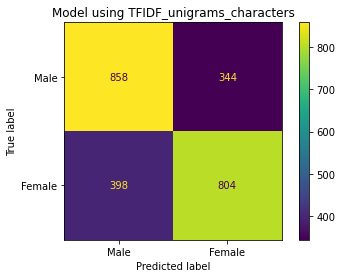

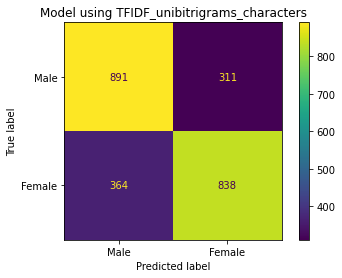

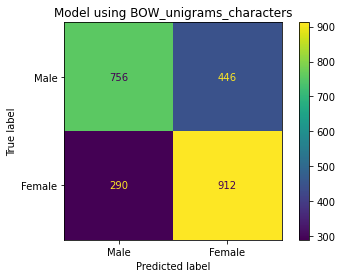

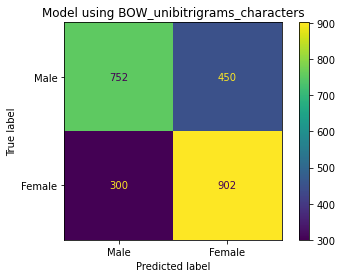

,model,Average train accuracy,Train accuracy std,Average test accuracy,Test accuracy std,Men accuracy,Women accuracy
TFIDF_unigrams_characters,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.985212,0.000609,0.695392,0.234702,0.713810,0.668885
TFIDF_unibitrigrams_characters,"{'C': 0.2, 'class_weight': None, 'dual': False...",1.000000,0.000000,0.722406,0.225684,0.741265,0.697171
BOW_unigrams_characters,"{'C': 0.05, 'class_weight': None, 'dual': Fals...",0.934836,0.000758,0.695503,0.243039,0.628952,0.758735
BOW_unibitrigrams_characters,"{'C': 1.0, 'class_weight': None, 'dual': False...",1.000000,0.000000,0.690182,0.247112,0.625624,0.750416


In [ ]:
# Collect accuracy measures

# Empty objects 
accuracy_summary = {'model': [], 'Average train accuracy':[],'Train accuracy std':[], 'Average test accuracy':[],'Test accuracy std':[], 'Men accuracy':[], 'Women accuracy':[]}
confusion_matrices = []

# Get info
for i in features:

    results = pickle.load(open( "datasets/cornell_corpus/results/cv_logistic_" + i + ".pickle", "rb" ))
    cv_scores = results['cv_scores']
    cv_predict = results['cv_predict']
    model = results['model']

    # Model
    accuracy_summary['model'].append(model)

    # Get average and standard deviation of train and test accuracy
    accuracy_summary['Average train accuracy'].append(np.mean(cv_scores['train_accuracy']))
    accuracy_summary['Train accuracy std'].append(np.std(cv_scores['train_accuracy']))
    accuracy_summary['Average test accuracy'].append(np.mean(cv_scores['test_accuracy']))
    accuracy_summary['Test accuracy std'].append(np.std(cv_scores['test_accuracy']))

    # Get confusion matrix
    cm = confusion_matrix(y_true = target, y_pred = cv_predict)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
    confusion_matrices.append(cmdisp)
    cmdisp.plot()
    plt.title('Model using ' + i)
    plt.show()

    # Accuracy by class
    accuracy_by_class = cm.diagonal()/cm.sum(axis=1)
    accuracy_summary['Men accuracy'].append(accuracy_by_class[0])   
    accuracy_summary['Women accuracy'].append(accuracy_by_class[1])   

pd.DataFrame(accuracy_summary, index = features.keys())

### Models using leave-some-movies-out

Leave-one-group-out cross-validation is used. In this case each group is a group of movies.  

In [ ]:
# Dictionary of features 
features = {'TFIDF_unigrams_characters': TFIDF_unigrams_characters, 'TFIDF_unibitrigrams_characters': TFIDF_unibitrigrams_characters, 'BOW_unigrams_characters': BOW_unigrams_characters, 'BOW_unibitrigrams_characters': BOW_unibitrigrams_characters}

# Apply Logistic regression with each set of features using leave-one-movie-out
for i in features:
    lr_leave_one_group_out(X = features[i], y = target, group = cornell_prepro_characters['movieGroup'], file_suffix = i , results_suffix = 'SomeMoviesOut', return_objects = False)    

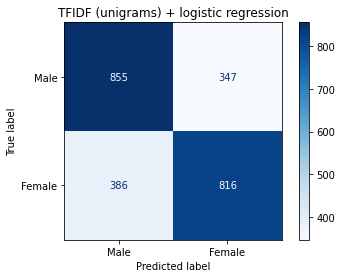

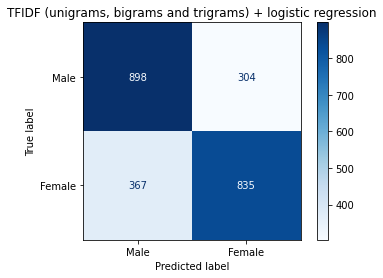

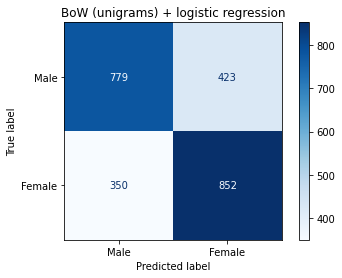

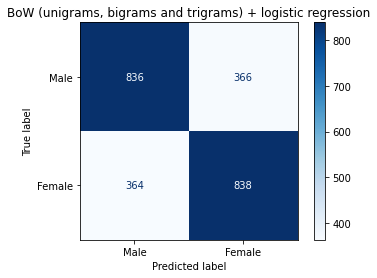

\begin{tabular}{llllll}
\toprule
                              Features &                                              Model & Avg. train accuracy ± std & Avg. test accuracy ± std & Avg. men accuracy ± std (on test) & Avg. women accuracy ± std (on test) \\
\midrule
                      TFIDF (unigrams) & \{'C': 0.2, 'class\_weight': None, 'dual': False,... &              98.97 ± 0.07 &             69.49 ± 2.36 &                      71.07 ± 2.55 &                        67.91 ± 2.96 \\
TFIDF (unigrams, bigrams and trigrams) & \{'C': 0.2, 'class\_weight': None, 'dual': False,... &               100.0 ± 0.0 &             72.09 ± 1.46 &                      74.71 ± 3.69 &                        69.47 ± 1.85 \\
                        BoW (unigrams) & \{'C': 0.2, 'class\_weight': None, 'dual': False,... &              98.84 ± 0.08 &             67.88 ± 1.18 &                      64.86 ± 1.77 &                        70.89 ± 0.95 \\
  BoW (unigrams, bigrams and trigrams) & \{'C': 0.05, 'c

,Features,Model,Avg. train accuracy ± std,Avg. test accuracy ± std,Avg. men accuracy ± std (on test),Avg. women accuracy ± std (on test)
0,TFIDF (unigrams),"{'C': 0.2, 'class_weight': None, 'dual': False...",98.97 ± 0.07,69.49 ± 2.36,71.07 ± 2.55,67.91 ± 2.96
1,"TFIDF (unigrams, bigrams and trigrams)","{'C': 0.2, 'class_weight': None, 'dual': False...",100.0 ± 0.0,72.09 ± 1.46,74.71 ± 3.69,69.47 ± 1.85
2,BoW (unigrams),"{'C': 0.2, 'class_weight': None, 'dual': False...",98.84 ± 0.08,67.88 ± 1.18,64.86 ± 1.77,70.89 ± 0.95
3,"BoW (unigrams, bigrams and trigrams)","{'C': 0.05, 'class_weight': None, 'dual': Fals...",100.0 ± 0.0,69.66 ± 1.18,69.6 ± 3.81,69.73 ± 1.99


In [ ]:
# Collect accuracy measures

# Empty objects 
accuracy_summary = {'Features': [], 'Model': [], 'Avg. train accuracy \u00B1 std':[], 'Avg. test accuracy \u00B1 std':[], 'Avg. men accuracy \u00B1 std (on test)':[], 'Avg. women accuracy \u00B1 std (on test)':[]}
names = ['TFIDF (unigrams)',  'TFIDF (unigrams, bigrams and trigrams)', 'BoW (unigrams)', 'BoW (unigrams, bigrams and trigrams)']

# Get info
for i, name in zip(features, names):

    results = pickle.load(open( "datasets/cornell_corpus/results/cv_logistic_" + i + 'SomeMoviesOut' + ".pickle", "rb" ))
    cv_scores = results['cv_scores']
    cv_predict = results['cv_predict']
    model = results['model']

    # Model
    accuracy_summary['Model'].append(model)
    accuracy_summary['Features'].append(name)

    # Get average and standard deviation of train and test accuracy
    accuracy_summary['Avg. train accuracy \u00B1 std'].append(str(np.round(np.mean(cv_scores['train_accuracy']) * 100, 2)) + ' \u00B1 ' + str(np.round(np.std(cv_scores['train_accuracy']) * 100, 2)))
    accuracy_summary['Avg. test accuracy \u00B1 std'].append(str(np.round(np.mean(cv_scores['test_accuracy']) * 100, 2)) + ' \u00B1 ' + str(np.round(np.std(cv_scores['test_accuracy']) * 100, 2)))
    
    men_accuracies = []
    women_accuracies = []
    for group in np.unique(cornell_prepro_characters['movieGroup']):
        group_preds = results['cv_predict'][cornell_prepro_characters['movieGroup'] == group]
        group_ground_truth = target[cornell_prepro_characters['movieGroup'] == group]
        men_accuracy = np.mean(group_ground_truth[group_ground_truth == 0] == group_preds[group_ground_truth == 0])
        women_accuracy = np.mean(group_ground_truth[group_ground_truth == 1] == group_preds[group_ground_truth == 1])
        men_accuracies.append(men_accuracy)
        women_accuracies.append(women_accuracy)
    accuracy_summary['Avg. men accuracy \u00B1 std (on test)'].append(str(np.round(np.mean(men_accuracies)*100, 2)) + ' \u00B1 ' + str(np.round(np.std(men_accuracies)*100, 2)))
    accuracy_summary['Avg. women accuracy \u00B1 std (on test)'].append(str(np.round(np.mean(women_accuracies)*100, 2)) + ' \u00B1 ' + str(np.round(np.std(women_accuracies)*100, 2)))

    # Get confusion matrix
    cm = confusion_matrix(y_true = target, y_pred = cv_predict)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
    cmdisp.plot(cmap = 'Blues')
    plt.title(name + ' + logistic regression')
    plt.show()

accuracy_summary = pd.DataFrame(accuracy_summary)

# Latex table
print(accuracy_summary.to_latex(index=False))
accuracy_summary

## 2. Naive bayes based models

We use Complement Naive Bayes since it's the naive bayes approach that has shown better results in text classification. [Complement Naives info here](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes)

### Grid search on Naive Bayes models

Using 5-fold

In [ ]:
hyperparameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'norm': [True, False]}

In [ ]:
# Function for gridsearch on Naive Bayes

def GridSearch_CNB(X, y, file_sufix, hyperparameters, verbose = 3, kfold_split = 5):
    '''
    Does gridsearch on a Complement Naive Bayes Model

    Inputs:
    X: a matrix of features (it is excepted to be the matrix resulting from using TF-IDF or Bag of Words)
    y: the target variable
    file_sufix: sufix to add at the end of the pickle file that saves the results
    hyperparameters: list of dictionaries or dictionary indicating the parameters to try
    '''
    # Using TFIDF on unigrams
    CNB = ComplementNB()
    CNBGridsearch = GridSearchCV(CNB, hyperparameters, cv = KFold(kfold_split), verbose = verbose)
    CNBGridsearch.fit(X, y)

    print('Best hyperameters', CNBGridsearch.best_params_)
    print('Best test accuracy', CNBGridsearch.best_score_)

    pickle.dump(CNBGridsearch, open("datasets/cornell_corpus/results/CNBGridsearch_" + file_sufix + ".pickle", "wb" ))

In [ ]:
# Apply gridsearch for each group of features
features = {'TFIDF_unigrams_characters': TFIDF_unigrams_characters, 'TFIDF_unibitrigrams_characters': TFIDF_unibitrigrams_characters, 'BOW_unigrams_characters': BOW_unigrams_characters, 'BOW_unibitrigrams_characters': BOW_unibitrigrams_characters}
for i in features:
    print('----------------')
    print('Gridsearch for', i) 
    print('----------------') 
    start_time = time.time()
    GridSearch_CNB(X = features[i], y = target, file_sufix = i, hyperparameters = hyperparameters, verbose = 1, kfold_split=5)
    print('Gridsearch execution time (minutes):', (time.time() - start_time) / 60)

----------------
Gridsearch for TFIDF_unigrams_characters
----------------
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best hyperameters {'alpha': 1, 'norm': False}
Best test accuracy 0.6838747401247401
Gridsearch execution time (minutes): 0.019629859924316408
----------------
Gridsearch for TFIDF_unibitrigrams_characters
----------------
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best hyperameters {'alpha': 0.1, 'norm': True}
Best test accuracy 0.7125667013167012
Gridsearch execution time (minutes): 0.040247106552124025
----------------
Gridsearch for BOW_unigrams_characters
----------------
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best hyperameters {'alpha': 10, 'norm': False}
Best test accuracy 0.6934338184338185
Gridsearch execution time (minutes): 0.01795769135157267
----------------
Gridsearch for BOW_unibitrigrams_characters
----------------
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best hyperameters {'alp

### Models using leave-one-movie-out

We use the hyperparameters recommended by the gridsearch to train our models. This time we use leave-one-movie-out cross-validation

In [ ]:
def CNB_leave_one_group_out(X, y, group, file_suffix, results_suffix = '', return_objects = False):
    '''
    Trains complete naive bayes classifier using leave-one-group-out cross-validation

    Inputs:
    X: a matrix of features (it is excepted to be the matrix resulting from using TF-IDF or Bag of Words)
    y: the target variable
    group: the variable that stablishes the group to do the leave one group out
    file_sufix: sufix to add at the end of the pickle file loads the results from the gridsearch 
    return_objects: whether to return of not the results of cross_validation and cross_val_predict
    
    Output: 
    A dictionary with
    cv_scores: the train and test accuracy in each iteration.
    cv_predict: predicted values for test samples. Of size equals to y.
    model: parameters of the model used 
    '''

    # Load best estimator for the grid search results
    CNB_grid_results = pickle.load(open('datasets/cornell_corpus/results/CNBGridsearch_' + file_suffix + '.pickle', 'rb'))
    CNB = CNB_grid_results.best_estimator_
    # Use leave-one-group-out
    groups = np.array(group)
    cv_scores = cross_validate(CNB, X = X , y = y, groups = groups, cv = LeaveOneGroupOut(), scoring = ['accuracy'], return_train_score = True)
    cv_predict = cross_val_predict(CNB, X = X , y = y, groups = groups, cv = LeaveOneGroupOut())
    # Save results
    results = {'cv_scores': cv_scores, 'cv_predict': cv_predict, 'model': CNB.get_params()}
    pickle.dump(results, open( "datasets/cornell_corpus/results/cv_CNB_" + file_suffix + results_suffix + ".pickle", "wb" ))
    # Return reseults if needed
    if return_objects:
        return results

In [ ]:
# Dictionary of features 
features = {'TFIDF_unigrams_characters': TFIDF_unigrams_characters, 'TFIDF_unibitrigrams_characters': TFIDF_unibitrigrams_characters, 'BOW_unigrams_characters': BOW_unigrams_characters, 'BOW_unibitrigrams_characters': BOW_unibitrigrams_characters}

# Apply Naive Bayes with each set of features using leave-one-movie-out
for i in features:
    CNB_leave_one_group_out(X = features[i], y = target, group = cornell_prepro_characters['movieID'], file_suffix = i, return_objects = False)    

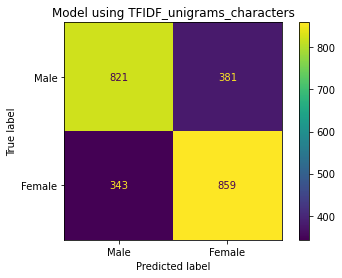

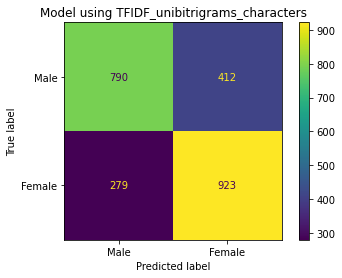

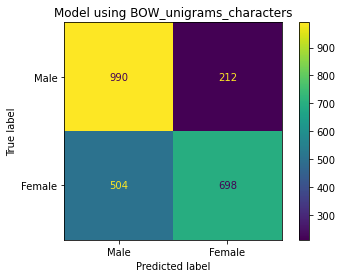

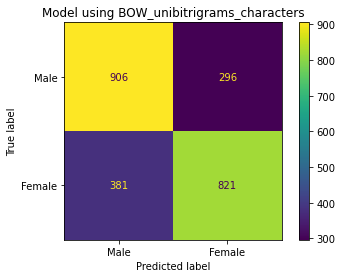

,model,Average train accuracy,Train accuracy std,Average test accuracy,Test accuracy std,Men accuracy,Women accuracy
TFIDF_unigrams_characters,"{'alpha': 1, 'class_prior': None, 'fit_prior':...",0.909626,0.000841,0.704931,0.232073,0.683028,0.714642
TFIDF_unibitrigrams_characters,"{'alpha': 0.1, 'class_prior': None, 'fit_prior...",0.994556,0.000165,0.720951,0.221838,0.657238,0.767887
BOW_unigrams_characters,"{'alpha': 10, 'class_prior': None, 'fit_prior'...",0.834755,0.000826,0.701249,0.227031,0.823627,0.580699
BOW_unibitrigrams_characters,"{'alpha': 1, 'class_prior': None, 'fit_prior':...",0.969106,0.000698,0.725125,0.225270,0.753744,0.683028


In [ ]:
# Collect accuracy measures

# Empty objects 
accuracy_summary = {'model': [], 'Average train accuracy':[],'Train accuracy std':[], 'Average test accuracy':[],'Test accuracy std':[], 'Men accuracy':[], 'Women accuracy':[]}
confusion_matrices = []

# Get info
for i in features:

    results = pickle.load(open( "datasets/cornell_corpus/results/cv_CNB_" + i + ".pickle", "rb" ))
    cv_scores = results['cv_scores']
    cv_predict = results['cv_predict']
    model = results['model']

    # Model
    accuracy_summary['model'].append(model)

    # Get average and standard deviation of train and test accuracy
    accuracy_summary['Average train accuracy'].append(np.mean(cv_scores['train_accuracy']))
    accuracy_summary['Train accuracy std'].append(np.std(cv_scores['train_accuracy']))
    accuracy_summary['Average test accuracy'].append(np.mean(cv_scores['test_accuracy']))
    accuracy_summary['Test accuracy std'].append(np.std(cv_scores['test_accuracy']))

    # Get confusion matrix
    cm = confusion_matrix(y_true = target, y_pred = cv_predict)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
    confusion_matrices.append(cmdisp)
    cmdisp.plot()
    plt.title('Model using ' + i)
    plt.show()

    # Accuracy by class
    accuracy_by_class = cm.diagonal()/cm.sum(axis=1)
    accuracy_summary['Men accuracy'].append(accuracy_by_class[0])   
    accuracy_summary['Women accuracy'].append(accuracy_by_class[1])   

pd.DataFrame(accuracy_summary, index = features.keys())

### Models using leave-some-movies-out

Leave-one-group-out cross-validation is used. In this case each group is a group of movies.  

In [ ]:
# Dictionary of features 
features = {'TFIDF_unigrams_characters': TFIDF_unigrams_characters, 'TFIDF_unibitrigrams_characters': TFIDF_unibitrigrams_characters, 'BOW_unigrams_characters': BOW_unigrams_characters, 'BOW_unibitrigrams_characters': BOW_unibitrigrams_characters}

# Apply Logistic regression with each set of features using leave-one-movie-out
for i in features:
    CNB_leave_one_group_out(X = features[i], y = target, group = cornell_prepro_characters['movieGroup'], file_suffix = i , results_suffix = 'SomeMoviesOut', return_objects = False)    

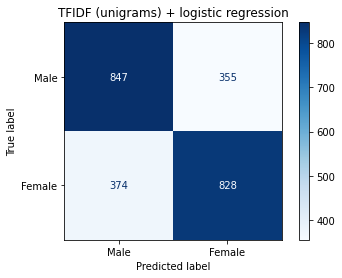

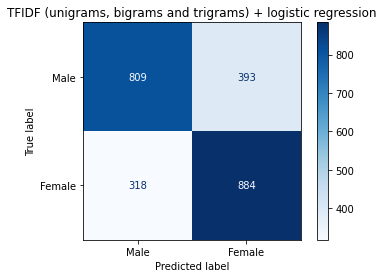

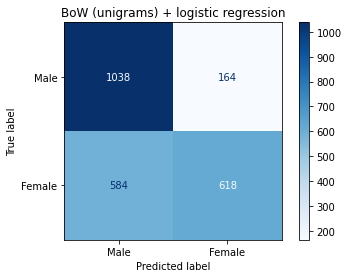

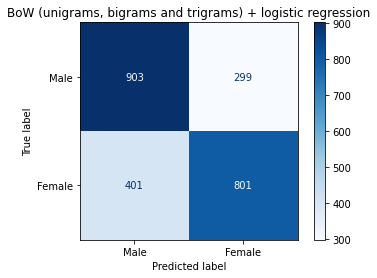

\begin{tabular}{llllll}
\toprule
                              Features &                                              Model & Avg. train accuracy ± std & Avg. test accuracy ± std & Avg. men accuracy ± std (on test) & Avg. women accuracy ± std (on test) \\
\midrule
                      TFIDF (unigrams) & \{'alpha': 1, 'class\_prior': None, 'fit\_prior': ... &              92.61 ± 0.48 &              69.7 ± 0.87 &                      70.49 ± 1.81 &                         68.9 ± 1.53 \\
TFIDF (unigrams, bigrams and trigrams) & \{'alpha': 0.1, 'class\_prior': None, 'fit\_prior'... &               99.6 ± 0.08 &              70.43 ± 0.9 &                      67.32 ± 1.45 &                        73.54 ± 1.23 \\
                        BoW (unigrams) & \{'alpha': 10, 'class\_prior': None, 'fit\_prior':... &              83.06 ± 0.55 &              68.9 ± 0.59 &                      86.39 ± 1.37 &                        51.41 ± 1.82 \\
  BoW (unigrams, bigrams and trigrams) & \{'alpha': 1

,Features,Model,Avg. train accuracy ± std,Avg. test accuracy ± std,Avg. men accuracy ± std (on test),Avg. women accuracy ± std (on test)
0,TFIDF (unigrams),"{'alpha': 1, 'class_prior': None, 'fit_prior':...",92.61 ± 0.48,69.7 ± 0.87,70.49 ± 1.81,68.9 ± 1.53
1,"TFIDF (unigrams, bigrams and trigrams)","{'alpha': 0.1, 'class_prior': None, 'fit_prior...",99.6 ± 0.08,70.43 ± 0.9,67.32 ± 1.45,73.54 ± 1.23
2,BoW (unigrams),"{'alpha': 10, 'class_prior': None, 'fit_prior'...",83.06 ± 0.55,68.9 ± 0.59,86.39 ± 1.37,51.41 ± 1.82
3,"BoW (unigrams, bigrams and trigrams)","{'alpha': 1, 'class_prior': None, 'fit_prior':...",97.95 ± 0.24,70.89 ± 1.25,75.14 ± 2.07,66.64 ± 1.63


In [ ]:
# Collect accuracy measures

# Empty objects 
accuracy_summary = {'Features': [], 'Model': [], 'Avg. train accuracy \u00B1 std':[], 'Avg. test accuracy \u00B1 std':[], 'Avg. men accuracy \u00B1 std (on test)':[], 'Avg. women accuracy \u00B1 std (on test)':[]}
names = ['TFIDF (unigrams)',  'TFIDF (unigrams, bigrams and trigrams)', 'BoW (unigrams)', 'BoW (unigrams, bigrams and trigrams)']

# Get info
for i, name in zip(features, names):

    results = pickle.load(open( "datasets/cornell_corpus/results/cv_CNB_" + i + 'SomeMoviesOut' + ".pickle", "rb" ))
    cv_scores = results['cv_scores']
    cv_predict = results['cv_predict']
    model = results['model']

    # Model
    accuracy_summary['Model'].append(model)
    accuracy_summary['Features'].append(name)

    # Get average and standard deviation of train and test accuracy
    accuracy_summary['Avg. train accuracy \u00B1 std'].append(str(np.round(np.mean(cv_scores['train_accuracy']) * 100, 2)) + ' \u00B1 ' + str(np.round(np.std(cv_scores['train_accuracy']) * 100, 2)))
    accuracy_summary['Avg. test accuracy \u00B1 std'].append(str(np.round(np.mean(cv_scores['test_accuracy']) * 100, 2)) + ' \u00B1 ' + str(np.round(np.std(cv_scores['test_accuracy']) * 100, 2)))
    
    men_accuracies = []
    women_accuracies = []
    for group in np.unique(cornell_prepro_characters['movieGroup']):
        group_preds = results['cv_predict'][cornell_prepro_characters['movieGroup'] == group]
        group_ground_truth = target[cornell_prepro_characters['movieGroup'] == group]
        men_accuracy = np.mean(group_ground_truth[group_ground_truth == 0] == group_preds[group_ground_truth == 0])
        women_accuracy = np.mean(group_ground_truth[group_ground_truth == 1] == group_preds[group_ground_truth == 1])
        men_accuracies.append(men_accuracy)
        women_accuracies.append(women_accuracy)
    accuracy_summary['Avg. men accuracy \u00B1 std (on test)'].append(str(np.round(np.mean(men_accuracies)*100, 2)) + ' \u00B1 ' + str(np.round(np.std(men_accuracies)*100, 2)))
    accuracy_summary['Avg. women accuracy \u00B1 std (on test)'].append(str(np.round(np.mean(women_accuracies)*100, 2)) + ' \u00B1 ' + str(np.round(np.std(women_accuracies)*100, 2)))

    # Get confusion matrix
    cm = confusion_matrix(y_true = target, y_pred = cv_predict)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
    cmdisp.plot(cmap = 'Blues')
    plt.title(name + ' + logistic regression')
    plt.show()

accuracy_summary = pd.DataFrame(accuracy_summary)

# Latex table
print(accuracy_summary.to_latex(index=False))
accuracy_summary

## 3. Model using the best results from leave-some-movies-out

We consider the best model among logistic regression and CNB models.
Note that no train test splitting is done since we already assessed the accuracy with leave-one-group-out cross-validation.
We are just interested in getting the coefficients for their interpretations.  

In [14]:
features = {'TFIDF_unigrams_characters': TFIDF_unigrams_characters, 'TFIDF_unibitrigrams_characters': TFIDF_unibitrigrams_characters, 'BOW_unigrams_characters': BOW_unigrams_characters, 'BOW_unibitrigrams_characters': BOW_unibitrigrams_characters}

chosen_features = 'TFIDF_unibitrigrams_characters'

# Load best estimator for the grid search results
lr_grid_results = pickle.load(open('datasets/cornell_corpus/results/logisticGridsearch_' + chosen_features + '.pickle', 'rb'))
lr = lr_grid_results.best_estimator_
# Train the model
scaler = preprocessing.MaxAbsScaler()
X = scaler.fit_transform(X = features[chosen_features])
lr.fit(X = X, y = target)

LogisticRegression(C=0.2, max_iter=1000, random_state=140, solver='newton-cg')

In [21]:
# get coefficients by word
logistic_reg_coefs = pd.DataFrame({'words' : TFIDF_model_unibitrigrams.get_feature_names_out(), 'coef': lr.coef_[0]}).sort_values(by=['coef'])
logistic_reg_coefs['exp(coef)'] = np.exp(logistic_reg_coefs['coef'])
logistic_reg_coefs = logistic_reg_coefs.round(2)
logistic_reg_coefs.to_csv('results/models/lr_TFIDF_unibitrigrams_characters_coef.csv')

# Extracting the top and bottom coefs
print(logistic_reg_coefs[0:25].to_latex(index = False))
print(logistic_reg_coefs.sort_values(by=['coef'], ascending = False)[0:25].to_latex(index = False))

\begin{tabular}{lrr}
\toprule
     words &  coef &  exp(coef) \\
\midrule
       the & -0.51 &       0.60 \\
       got & -0.47 &       0.63 \\
        on & -0.38 &       0.69 \\
      here & -0.37 &       0.69 \\
       hey & -0.36 &       0.70 \\
     right & -0.36 &       0.70 \\
        of & -0.33 &       0.72 \\
       her & -0.32 &       0.73 \\
     there & -0.31 &       0.73 \\
      yeah & -0.30 &       0.74 \\
       man & -0.28 &       0.75 \\
     gotta & -0.28 &       0.76 \\
    her to & -0.28 &       0.76 \\
   my wife & -0.27 &       0.76 \\
       she & -0.27 &       0.76 \\
   running & -0.27 &       0.76 \\
      shes & -0.27 &       0.76 \\
understand & -0.27 &       0.77 \\
   hey you & -0.27 &       0.77 \\
  there is & -0.26 &       0.77 \\
        up & -0.26 &       0.77 \\
     could & -0.26 &       0.77 \\
   problem & -0.25 &       0.78 \\
   its the & -0.24 &       0.78 \\
      shit & -0.24 &       0.78 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\to